###  Created by Luis A. Sanchez-Perez (alejand@umich.edu).
<p><span style="color:green"><b>Copyright &#169;</b> Do not distribute or use without authorization from author.</span></p>

<p><span style="color:red"><b>Note: </b> For this notebook I recommend to focus first on <b>Step 5</b> and then review the rest of it. However you need to run all cells before <b>Step 5</b>.</span></p>

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from numerical_gradient import approximate_gradient
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import os
import pathlib
from pynput import keyboard
import threading

### 1. Read a prepares dataset for training
Here we are reading a simple dataset. We will use only one feature.

In [2]:
# Reads dataset
DATASETS = pathlib.Path(os.environ['DATASETS'])
dataset = pd.read_csv(DATASETS / 'datasets/others/tremors/tremors.csv')
dataset = dataset.dropna()
dataset.head()

,amplitude,pct100-90,pct90-70,pct70-50,unconstrained,constrained,freq,fuzzy score,expert score,limb
0,0.6931,1.2570,4.7486,21.5084,0.8542,0.5706,5.5047,0.776057,1,RUE
1,0.1140,4.7393,3.7915,9.4787,0.0385,0.1895,6.3016,0.146397,0,LUE
2,0.0000,0.0000,0.0000,0.0000,0.0003,0.0049,6.6038,0.000501,0,RLE
3,0.0000,0.0000,0.0000,0.0000,0.0007,0.0059,6.9767,0.000501,0,LLE
4,0.0678,1.1076,5.0633,10.7595,0.5125,0.5402,6.1854,0.092817,0,RUE


In [3]:
# Init data
X = dataset.iloc[:,[0]].values
y = dataset['fuzzy score'].values
m,d = X.shape
# Adds column of ones!
X = np.hstack((np.ones((m,1)),X))

### 2. Implementation of the optimizers
Down below you will find definitions for the following classes:
* `Param`: A class to hold parameters.
* `Optimizer`: An abstract class (base class) for any optimizer implemented later.
* `BatchGradientDescendOptimizer`: An optimizer class implementing the update rule used in Batch Gradient Descend.
* `LineSearchOptimizer`: An optimizer class updating parameters based on Line Search.
* `NewtonsMethodOptimizer`: An optimizer class updating parameters based on Newton's Method.
* `AdagradOptimizer`: An optimizer class updating parameters using Adagrad (adaptative learning rate).

In [4]:
class Param:
    """
    Simple class to hold parameters
    """
    def __init__(self, shape):
        super().__init__()
        self.value = np.zeros(shape)

In [5]:
class Optimizer:
    """
    Abstract optimizer implementation
    """        
    def update(self, params, gradients, hessian=None):
        raise NotImplementedError("Must override update method")
        
    def reset(self, params):
        raise NotImplementedError("Must override reset method")

In [6]:
class BatchGradientDescendOptimizer(Optimizer):
    """
    Basic gradient descend optimizer (better known as batch gradient descend).
    """
    def __init__(self, **opts):
        self.alpha = 1e-3 if 'alpha' not in opts else opts['alpha']
        
    def update(self, params, gradients, hessian=None):
        for param, grad in zip(params, gradients):
            step = self.alpha * grad
            param.value -= step
            
    def reset(self, params):
        pass

In [7]:
class LineSearchOptimizer(Optimizer):
    """
    Basic Line Search optimizer. It needs the Hessian matrix.
    """
    def update(self, params, gradients, hessians=None):
        for param, grad, hessian in zip(params, gradients, hessians):
            alpha = (grad.T).dot(grad) / (grad.T).dot(hessian).dot(grad)
            step = alpha * grad
            param.value -= step
            
    def reset(self, params):
        pass

In [8]:
class NewtonsMethodOptimizer(Optimizer):
    """
    Basic Newton's Method optimizer. It needs the Hessian matrix.
    """
    def update(self, params, gradients, hessians=None):
        for param, grad, hessian in zip(params, gradients, hessians):
            step = np.linalg.solve(hessian, grad)
#             step = np.linalg.inv(hessian).dot(grad)
            param.value -= step  
            
    def reset(self, params):
        pass

In [9]:
class AdagradOptimizer(Optimizer):
    """
    Adagrad optimizer. It uses an adaptative learning rate per component of the gradient. The learning rate is
    adjusted based on the cumulative gradient from previous iterations (each component treated independently).
    """
    def __init__(self, **opts):
        self.alpha = 1 if 'alpha' not in opts else opts['alpha']
        self.epsilon = 1e-10 if 'epsilon' not in opts else opts['epsilon']
        self.cumulative = {}
    
    def reset(self, params):
        for param in params:
            self.cumulative[param] = np.zeros((param.value.shape))
            
    def update(self, params, gradients):
        for param, grad in zip(params, gradients):
            self.cumulative[param] += (grad**2)
            step = self.alpha / (np.sqrt(self.cumulative[param]) + self.epsilon) * grad
            param.value -= step

### 3. Implementation of the training

Below we implement some functions related to Linear Regression needed to perform gradient descent optimization.   

In [10]:
# Function to compute cost in Linear Regression
def compute_cost(y, h):
    residual = h - y 
    return (1/residual.shape[0])*((residual.T).dot(residual))

# Function to compute gradient in Linear Regression
def compute_gradient(X, y, h):
    residual = h - y  
    return (X.T).dot(residual)

# Function to compute Hessian in Linear Regression
def compute_hessian(X):
    return (X.T).dot(X)

Below we implement the training of a Linear Regression model using each of the `optimizers`. Therefore we perform `len(optimizers)` different trainings for which we collect store the cost and weights after each training step.

In [11]:
def train(point, optimizers, epochs=200, batch_size=None, steps_per_epoch=None, epsilon=1e-5, early_stopping_steps=10):
    # Creates weights param
    weights = Param((2,))
    # How many batches?
    if batch_size is None:
        steps_per_epoch = 1
        num_batches = None
    else:
        num_batches = int(np.ceil(m/batch_size))
        if steps_per_epoch is None:
            steps_per_epoch = num_batches
    # We store the results of the trainings here
    results = {}
    # Loops through each optimizer
    for optimizer in optimizers:
        # Reset weights to initial value
        weights.value = np.array(point, dtype=np.float32)
        optimizer.reset([weights])
        # Computes and stores the cost for the initial weights
        history = []
        h = X.dot(weights.value)
        J = compute_cost(y, h)
        history.append((weights.value.copy(), J))
        # Training loop
        stop = False
        badsteps = 0
        for epoch in range(epochs):
            # Shuffles indexes of observation to generate random batches
            batch_indexes = np.random.permutation(m)
            # Performs steps for this epoch
            for step in range(steps_per_epoch):
                # Determines gradient of weights
                if batch_size is None:
                    h = X.dot(weights.value)
                    grad = compute_gradient(X, y, h)
                else:
                    start = step % num_batches
                    samples = batch_indexes[start * batch_size : (start + 1) * batch_size]
                    h = X[samples,:].dot(weights.value)
                    grad = compute_gradient(X[samples,:], y[samples], h)

                # Updates weights
                if isinstance(optimizer, (LineSearchOptimizer, NewtonsMethodOptimizer)):
                    optimizer.update([weights], [grad], [compute_hessian(X)])
                else:
                    optimizer.update([weights], [grad])
                    
                # Computes new cost after weights update
                h = X.dot(weights.value)
                J = compute_cost(y, h)
                
                # Check if we the cost has gone crazy!
                if np.isinf(J) or np.isnan(J):
                    stop = True
                    break
                history.append([weights.value.copy(), J])
                delta = history[-2][1] - history[-1][1]
                # Check whether cost function changed enough
                if abs(delta) < epsilon:
                    stop = True
                    break
                # Early stopping
                badsteps = badsteps + 1 if delta < 0 else 0
                if badsteps > early_stopping_steps:
                    stop = True
                    break    
            # Any exit condition met?
            if stop:
                break
        # Logs message after training with optimizer
        print('Cost {} after {} steps (with {})'.format(
            history[-1][1],
            len(history) - 1,
            type(optimizer).__name__))
        # Stores results
        results[optimizer] = history
        
    # Outputs results for all optimizers    
    return results

### 4. Implementation of an animation to show the results of the training
Down below we implement an animation to preview the progress recorded during training (for each of the `optimizers`).

In [12]:
# Names for legends
names = {
    LineSearchOptimizer.__name__: "Line Search",
    NewtonsMethodOptimizer.__name__: "Newton's Method",
    BatchGradientDescendOptimizer.__name__: "GD",
    AdagradOptimizer.__name__: "Adagrad"
}

In [13]:
# Some helper functions
def maximum_steps(data):
    return max([len(data[optimizer]) for optimizer in data])
def maximum_cost(data):
    return max([entry[1] for optimizer in data for entry in data[optimizer]])

In [14]:
# Helper class to generate training animation provided you pass proper training data.
class TrainingAnimation:
    def __init__(self, data):
        self.data = data
        self.costs = None
        self.paths = None
        self.fits = None
        self.current = 0
        self.lock = threading.Lock()
        
    # Plots the linear fit graph and returns a dictionary of artists where keys are optimizers
    def _plot_fit(self, ax):
        ax.scatter(X[:,1], y, c='k', s=15)
        artists = {}
        for optimizer in self.data: 
            line, = ax.plot([],[],label=names[type(optimizer).__name__])
            artists[optimizer] = line
        ax.set_title('Linear fit')
        ax.set_xlabel('$y$')
        ax.set_ylabel('$x$')
        ax.set_xlim([0,8])
        ax.set_ylim([0,4])
        ax.grid()
        return artists
    
    def _plot_contour(self, ax):
        # Building mesh
        pts = 50
        w0 = np.linspace(-10,10,pts)
        w1 = np.linspace(-10,10,pts)
        spacing = (w0.max() - w0.min())/pts
        w0,w1 = np.meshgrid(w0,w1)
        mesh = np.vstack((w0.flatten(), w1.flatten()))
        mesh_cost = (1/X.shape[0])*((X.dot(mesh) - y.reshape(len(y),1))**2).sum(axis=0).reshape(pts,pts)
        dw0,dw1 = approximate_gradient(mesh_cost, spacing)
        # Actual plot
        ax.contour(w0, w1, mesh_cost, levels=25, alpha=0.7)
        gstep = 6
        ax.quiver(w0[::gstep,::gstep],w1[::gstep,::gstep],-dw0[::gstep,::gstep],-dw1[::gstep,::gstep], width=0.003, alpha=0.5)
        artists = {}
        for optimizer in self.data: 
            line, = ax.plot([],[], '-')
            artists[optimizer] = line
        ax.plot(self.data[optimizer][0][0][0], self.data[optimizer][0][0][1], 'k.', label='Initial Params', markersize=15)
        ax.set_title('Cost function $J(w)$')
        ax.grid()
        return artists
    
    def _plot_cost(self, ax):
        artists = {}
        for optimizer in self.data: 
            line, = ax.plot([],[], '-')
            artists[optimizer] = line
        ax.set_title('Cost function $J(w)$')
        ax.set_xlabel('Step')
        ax.grid()
        ax.set_xlim([0, maximum_steps(self.data)])
        ax.set_ylim([0, maximum_cost(self.data)])
        return artists

    # Updates data of artists from data available
    def _plot_frame(self, frame):   
        for optimizer in self.data:
            history = self.data[optimizer]
            step = frame if frame < len(history) else len(history) - 1            
            cost = self.costs[optimizer]
            path = self.paths[optimizer]
            fit = self.fits[optimizer]
            if step < len(history):
                # Linear fit
                xdata = np.array([X[:,1].min(),X[:,1].max()])
                ydata = np.array([[1,X[:,1].min()],[1,X[:,1].max()]]).dot(history[step][0])
                fit.set_data(xdata, ydata)
                # 2D Path
                xdata = [entry[0][0] for entry in history[:step+1]]
                ydata = [entry[0][1] for entry in history[:step+1]]
                path.set_data(xdata, ydata)
                # Cost
                xdata = range(0,step+1)
                ydata = [entry[1] for entry in history[:step+1]]
                cost.set_data(xdata, ydata)
    
    # Keyboard listener
    def stop(self, key):
        if key == keyboard.Key.esc:
            with self.lock:
                self.current = maximum_steps(self.data) - 1
    
    def start(self):
        # Creates figure
        fig = plt.figure(figsize=(17,4))
        fig.subplots_adjust(top=1.2, bottom = 0.3)
        # Creates axes
        ax_fit = fig.add_subplot(131)
        ax_contour = fig.add_subplot(132)
        ax_cost = fig.add_subplot(133)
        # Plots static data and gets referere for updating data
        self.fits = self._plot_fit(ax_fit)
        self.paths = self._plot_contour(ax_contour)
        self.costs = self._plot_cost(ax_cost)
        # Performs animation by updating data
        self._plot_frame(self.current)
        fig.legend(loc=8)
        # Keyboard listener to stop animation
        listener = keyboard.Listener(on_press=self.stop)
        listener.start()
        # Looping through steps
        while self.current < maximum_steps(self.data):
            with self.lock:
                self._plot_frame(self.current)
                display(fig)
                clear_output(wait=True)
                self.current += 1
            plt.pause(0.1)

### 5. Visualizing the performance of different optimizers in a simple linear regression training task
Here we mainly test two things:
* Different optimizers.
* Different starting point.

I also recommend you play around with the `optimizers` configuration as well as the starting `point` and observed the results.

<p><span style="color:red"><b>Note: </b> To exit any animation you can press `Esc`.</span></p>

In [15]:
# Starting point to initialize the params
point = [2, -10]
# Creates different optimizers to train on
optimizers = [
    BatchGradientDescendOptimizer(alpha=1e-3),
    LineSearchOptimizer(),
    NewtonsMethodOptimizer(),
    AdagradOptimizer(alpha=5)
]
# Trains with the different optimizers
log = train(point, optimizers)

Cost 0.03252150859196152 after 34 steps (with BatchGradientDescendOptimizer)
Cost 0.03250810422631703 after 11 steps (with LineSearchOptimizer)
Cost 0.032506681619345446 after 2 steps (with NewtonsMethodOptimizer)
Cost 0.032511726975977276 after 23 steps (with AdagradOptimizer)


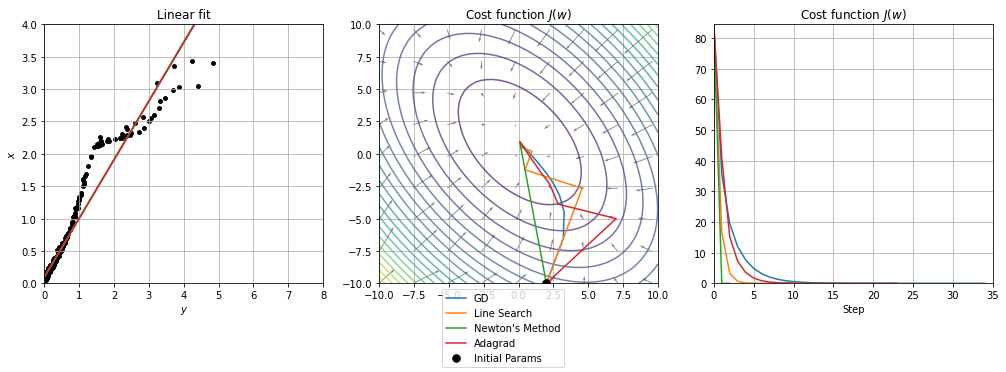

In [16]:
TrainingAnimation(log).start()

In [17]:
# Starting point to initialize the params
point = [-10, -2.5]
# Creates different optimizers to train on
optimizers = [
    BatchGradientDescendOptimizer(alpha=0.001),
    LineSearchOptimizer(),
    NewtonsMethodOptimizer(),
    AdagradOptimizer(alpha=3)
]
# Trains with the different optimizers
log = train(point, optimizers)

Cost 0.032520086243413314 after 30 steps (with BatchGradientDescendOptimizer)
Cost 0.032506692268517476 after 6 steps (with LineSearchOptimizer)
Cost 0.032506681619345446 after 2 steps (with NewtonsMethodOptimizer)
Cost 0.03253445250409422 after 55 steps (with AdagradOptimizer)


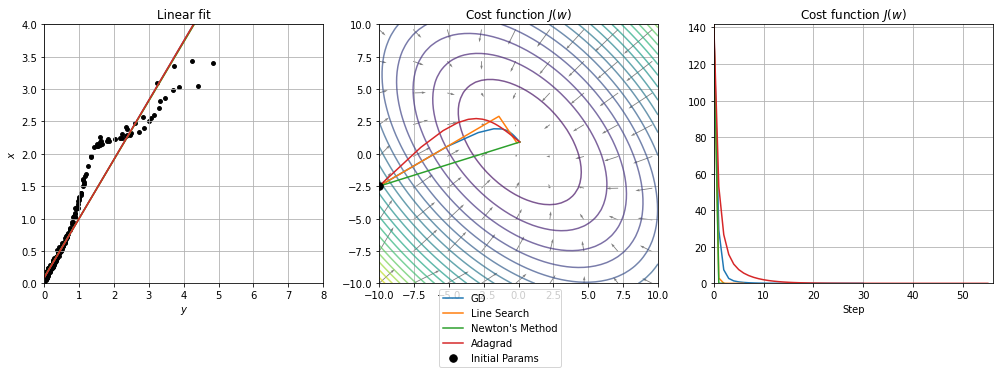

In [18]:
TrainingAnimation(log).start()